## Exploração do corpus de respostas

Este caderno apresenta a análise exploratória do corpus anotado com tipos de
resposta (subinformativa, sobreinformativa, completa e indefinida).
O meu objetivo é descrever a distribuição das classes, investigar propriedades
básicas das respostas e documentar as decisões metodológicas adotadas antes
da etapa de modelagem automática.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Descrição do corpus

O corpus utilizado corresponde à versão final das anotações, resultante da combinação entre anotação automática e revisão manual. Para as análises seguintes, utiliza-se a coluna classe_final como rótulo de referência.

In [18]:
df = pd.read_csv("corpus_final.csv")

## Seleção das colunas relevantes

Embora o arquivo original contenha diferentes colunas relacionadas ao processo
de anotação, este estudo utiliza apenas as informações necessárias para a
análise linguística e a modelagem computacional: a pergunta, a resposta e o
rótulo final do tipo de resposta.


In [19]:
df = df[["id", "pergunta", "resposta", "classe_final"]]
df = df.rename(columns={"classe_final": "tipo_resposta"})


## Checagens iniciais

Nesta etapa, verificam-se a integridade do corpus, a presença de valores
ausentes e a distribuição inicial dos rótulos. Essas checagens são
essenciais para garantir a confiabilidade das análises subsequentes.


In [20]:
df.info()
df.isna().sum()

df["tipo_resposta"].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             300 non-null    int64 
 1   pergunta       300 non-null    object
 2   resposta       300 non-null    object
 3   tipo_resposta  300 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.5+ KB


tipo_resposta
sobreinformativa    97
subinformativa      81
indefinida          61
completa            61
Name: count, dtype: int64

## Padronização dos rótulos

Os rótulos das classes são padronizados para evitar variações ortográficas
que possam afetar as análises e os modelos computacionais.


In [21]:
df["tipo_resposta"] = (
    df["tipo_resposta"]
    .str.lower()
    .str.strip()
)


In [22]:
df["tipo_resposta"].value_counts()


tipo_resposta
sobreinformativa    97
subinformativa      81
indefinida          61
completa            61
Name: count, dtype: int64

## Distribuição dos tipos de resposta

A seguir, apresenta-se a distribuição dos tipos de resposta no corpus,
incluindo a classe *indefinida*. Essa classe reflete casos limítrofes ou
ambíguos do fenômeno analisado e é mantida nesta etapa para fins descritivos.


In [23]:
dist_classes = (
    df["tipo_resposta"]
    .value_counts()
    .reset_index()
)

dist_classes.columns = ["tipo_resposta", "frequencia"]
dist_classes



,tipo_resposta,frequencia
0,sobreinformativa,97
1,subinformativa,81
2,indefinida,61
3,completa,61


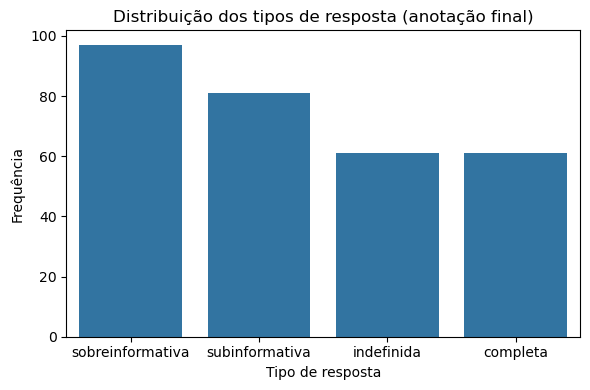

In [11]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=dist_classes,
    x="tipo_resposta",
    y="frequencia"
)
plt.title("Distribuição dos tipos de resposta (anotação final)")
plt.xlabel("Tipo de resposta")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


## Comprimento das respostas

Uma das hipóteses linguísticas subjacentes ao estudo é que respostas
sobreinformativas tendem a apresentar maior extensão textual, enquanto
respostas subinformativas são, em média, mais curtas. Para investigar essa
hipótese, são analisadas medidas simples de comprimento das respostas.


In [24]:
df["n_tokens"] = df["resposta"].apply(lambda x: len(str(x).split()))
df["n_chars"] = df["resposta"].apply(lambda x: len(str(x)))


In [25]:
df.groupby("tipo_resposta")[["n_tokens", "n_chars"]].mean()
df.groupby("tipo_resposta")[["n_tokens", "n_chars"]].std()

,n_tokens,n_chars
tipo_resposta,,
completa,0.881194,5.995536
indefinida,1.003001,5.738281
sobreinformativa,0.583824,3.713019
subinformativa,0.249691,3.526268


## Visualização do comprimento das respostas

O boxplot a seguir permite comparar a distribuição do número de tokens entre
os diferentes tipos de resposta, evidenciando possíveis diferenças
sistemáticas entre as classes.


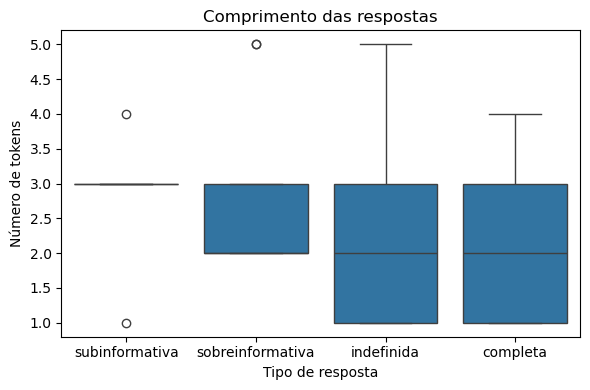

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x="tipo_resposta",
    y="n_tokens"
)
plt.title("Comprimento das respostas")
plt.xlabel("Tipo de resposta")
plt.ylabel("Número de tokens")
plt.tight_layout()
plt.show()
plt.savefig("comprimento_respostas_tipos.png", dpi=300)


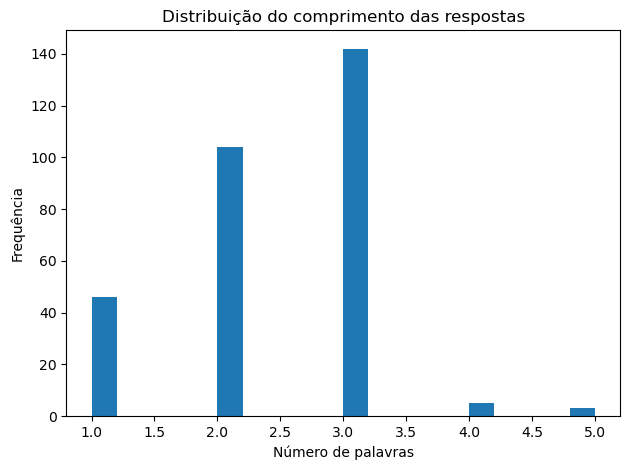

In [12]:
df["len_resposta"] = df["resposta"].str.split().str.len()

plt.hist(df["len_resposta"], bins=20)
plt.title("Distribuição do comprimento das respostas")
plt.xlabel("Número de palavras")
plt.ylabel("Frequência")

plt.tight_layout()
plt.savefig("comprimento_respostas.png", dpi=300)
plt.show()


## Decisão metodológica sobre a classe *indefinida*

Embora a classe *indefinida* seja relevante do ponto de vista teórico, ela
apresenta baixa consistência categorial e dificulta a aprendizagem automática
nas etapas iniciais. Por esse motivo, essa classe é mantida apenas na análise
descritiva e excluída da modelagem computacional.


In [23]:
df_model = df[df["tipo_resposta"] != "indefinida"]
df_model["tipo_resposta"].value_counts()


tipo_resposta
sobreinformativa    97
subinformativa      81
completa            61
Name: count, dtype: int64

## Exemplos prototípicos do corpus de modelagem

A seguir, são apresentados exemplos representativos de cada tipo de resposta
no corpus de modelagem, com o objetivo de ilustrar qualitativamente as
diferenças entre as classes.


In [24]:
for classe in ["subinformativa", "completa", "sobreinformativa"]:
    subset = df_model[df_model["tipo_resposta"] == classe]
    print(f"\n### {classe.upper()}")
    exemplos = subset.sample(2, random_state=42)
    for _, row in exemplos.iterrows():
        print("Pergunta:", row["pergunta"])
        print("Resposta:", row["resposta"])
        print("-" * 50)



### SUBINFORMATIVA
Pergunta: O avião e o helicótero decolaram?
Resposta: O avião decolou.
--------------------------------------------------
Pergunta: O João e a Maria foram à festa?
Resposta: A Maria foi.
--------------------------------------------------

### COMPLETA
Pergunta: O Pedro e a Ana chegaram ao cinema?
Resposta: Não chegaram.
--------------------------------------------------
Pergunta: O professor e os alunos compareceram à aula?
Resposta: Sim, eles compareceram.
--------------------------------------------------

### SOBREINFORMATIVA
Pergunta: O Gabriel falou com o diretor?
Resposta: Todos falaram.
--------------------------------------------------
Pergunta: A Bruna participou do jogo?
Resposta: Ninguém participou.
--------------------------------------------------


In [25]:
df_model.to_csv("corpus_modelagem.csv", index=False)


## Conclusão

A análise exploratória do corpus revelou diferenças sistemáticas entre os tipos
de resposta quanto à sua distribuição e ao comprimento médio das respostas.
Esses resultados fundamentam as etapas subsequentes do projeto, dedicadas à
classificação automática dos tipos de resposta por meio de modelos de PLN.
